# Introduction

In this tutorial we will extend previously developed fraud prediction system by adding Data Quality Monitoring for online features.

If you haven't already please check out these two tutorials first:
1. [Fraud Detection (with BigQuery and Datastore)](https://github.com/feast-dev/feast-gcp-fraud-tutorial/blob/main/notebooks/Fraud_Detection_Tutorial.ipynb)
2. [Validation of historical features with Great Expectations](https://docs.feast.dev/tutorials/validating-historical-features)

Throughout this tutorial, we’ll briefly revisit set up of feature store for the fraud detection system and then we'll walk through the creation of validation expectations, configuration of the online features logging and will check how to apply validation in production.

*The need to revisit the system desribed in [previous tutorial](https://github.com/feast-dev/feast-gcp-fraud-tutorial/blob/main/notebooks/Fraud_Detection_Tutorial.ipynb) is caused by the fact that Go feature server, which can produce feature logs used in validation, currently supports only Redis online store, whereas previous tutorial was using Datastore.*

Here's a high-level diagram desribing data flow in DQM pipeline:




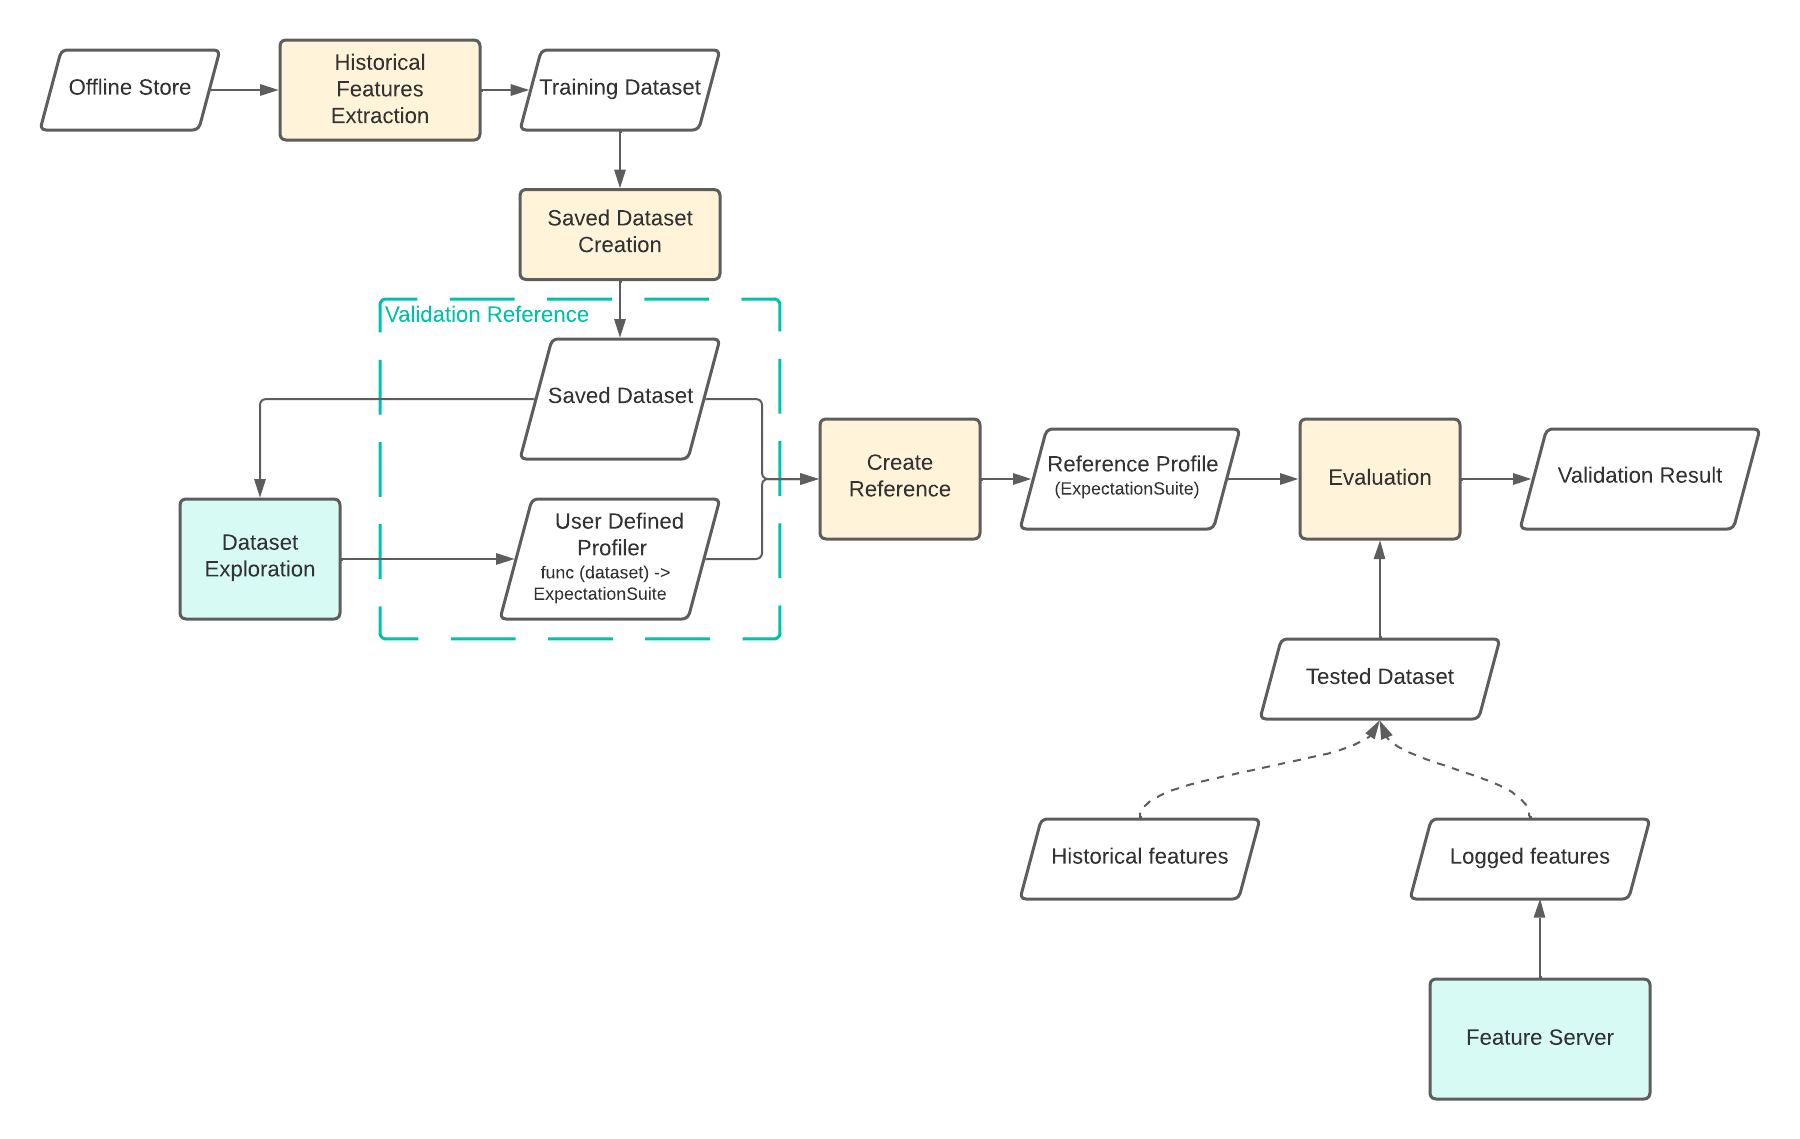

It all starts from generating a training dataset (by pulling historical features from an offline store). This training dataset serves as a validation reference. When a data scientist develops a model some set of implicit expectations from the training dataset appears. Those expectations, first of all, should be met by the training dataset itself and only then we can apply them to the online features in production.

Hence, on the second step the data scientist explores the dataset and develops or formalizes those expectations with help of [Great Expectations library](https://docs.greatexpectations.io/docs/). Those expectations can be checked right aways against training dataset and only those that pass on it will be added to a reference profile. Reference profile is a set of expectations that could be serialzed and later checked against tested dataset w/o the need to load the training dataset again.

On the evaluation stage a tested dataset is loaded from a storage and validated against a reference profile.

What you'll need for this tutorial:
1. GCP Account with access to BigQuery
2. Redis server (accessible locally)
3. (for Windows / Mac M1 users) installed Go compiler (=> 1.17) to build parts of Feast written in Go 

# Part I (feature store for fraud detection system on Redis)

So let's first recall the basics of the feature store creation.

## Installation and set up

### Install Feast

Feast can be installed using pip. This installation includes a Python package as well as a CLI.

Feast contains some packages which conflict with the default versions installed in Colab. **After running this cell, restart the runtime to continue** (Runtime > Restart runtime.)


In [ ]:
%env COMPILE_GO=True
%env FEAST_USAGE=False

!pip install 'feast[gcp]'
!pip install 'feast[redis]'
!pip install 'feast[ge]'
!pip install 'feast[go]'
!feast version

## Set configurations

Set the following configuration, which we'll be using throughout the tutorial:

- PROJECT_ID: Your project.
- BIGQUERY_DATASET_NAME: The name of a dataset which will be used to create tables containing features and store the logs of the feature server.

In [ ]:
PROJECT_ID = ""
BIGQUERY_DATASET_NAME = ""

## Create a BigQuery dataset
**Only if your dataset doesn't already exist**: Run the following cell to create your BigQuery dataset.

In [ ]:
! bq mk $BIGQUERY_DATASET_NAME

## Initialize the feature repository

In Feast, you define your features using configuration stored in a repository. To start, initialize a feature repository.

In [ ]:
! feast init fraud_tutorial
%cd fraud_tutorial/
! ls

Next, we'll edit the `feature_store.yaml` file to specify offline and online stores. Note that the `project` field in this file refers to the Feast concept of a project, not a GCP project.

In [ ]:
feature_store = \
f"""project: fraud_tutorial
registry: data/registry.db
provider: local
offline_store:
  type: bigquery
  dataset: {BIGQUERY_DATASET_NAME}
online_store:
  type: redis
  connection_string: "localhost:6379"
go_feature_retrieval: True
"""

with open('feature_store.yaml', "w") as feature_store_file:
    feature_store_file.write(feature_store)

# Print our feature_store.yaml
! cat feature_store.yaml

Then, we can apply our feature repository:

In [ ]:
! feast apply

## Creating features

Next, let's make a new feature and register it to the store.

This involves two steps.

- **Using Bigquery**, we generate new feature values using SQL. Feast is used not to generate features, which is done in Python/SQL.
- **Using Feast**, we register our new features in Feast by creating a FeatureView:



## Preview the raw data

In [ ]:
from google.cloud import bigquery
bq_client = bigquery.Client(project=PROJECT_ID)

In [ ]:
j = bq_client.query("select * from feast-oss.fraud_tutorial.transactions limit 1000")
j.to_dataframe()

## Create a feature table using SQL

Then, run the following cell to generate features. This cell contains two functions:

- `generate_user_count_features` runs a SQL query that counts the amount of transactions users have made as of a given point in time.

- `backfill_features` runs this query multiple times over an interval to backfill features.



In [ ]:
from datetime import datetime, timedelta
import time

def generate_user_count_features(aggregation_end_date):
    table_id  = f"{PROJECT_ID}.{BIGQUERY_DATASET_NAME}.user_count_transactions_7d"

    client = bigquery.Client(project=PROJECT_ID)
    job_config = bigquery.QueryJobConfig(destination=table_id, write_disposition='WRITE_APPEND')

    aggregation_start_date = datetime.now() - timedelta(days=7)

    sql = f"""
    SELECT
        src_account AS user_id,
        COUNT(*) AS transaction_count_7d,
        timestamp'{aggregation_end_date.isoformat()}' AS feature_timestamp
    FROM
        feast-oss.fraud_tutorial.transactions
    WHERE
        timestamp BETWEEN TIMESTAMP('{aggregation_start_date.isoformat()}')
        AND TIMESTAMP('{aggregation_end_date.isoformat()}')
    GROUP BY
        user_id
    """

    query_job = client.query(sql, job_config=job_config)
    query_job.result()
    print(f"Generated features as of {aggregation_end_date.isoformat()}")


def backfill_features(earliest_aggregation_end_date, interval, num_iterations):
    aggregation_end_date = earliest_aggregation_end_date
    for _ in range(num_iterations):
        generate_user_count_features(aggregation_end_date=aggregation_end_date)
        time.sleep(1)
        aggregation_end_date += interval

if __name__ == '__main__':
    backfill_features(
        earliest_aggregation_end_date=datetime.now() - timedelta(days=7),
        interval=timedelta(days=1),
        num_iterations=8
    )


Then, we can preview our new feature:

In [ ]:
j = bq_client.query(f"select * from {BIGQUERY_DATASET_NAME}.user_count_transactions_7d limit 1000")
j.to_dataframe()

## Create a new FeatureView

Create new files, `fraud_features.py`, which contains our new feature definition and `fraud_services.py`, which contains feature service definition.

In [ ]:
fraud_features = \
f"""
from datetime import timedelta
from feast import BigQuerySource, FeatureView, Entity, ValueType

# Add an entity for users
user_entity = Entity(
    name="user_id",
    description="A user that has executed a transaction or received a transaction",
)

# Add a FeatureView based on our new table
driver_stats_fv = FeatureView(
    name="user_transaction_count_7d",
    entities=[user_entity],
    ttl=timedelta(weeks=1),
    batch_source=BigQuerySource(
        table=f"{PROJECT_ID}.{BIGQUERY_DATASET_NAME}.user_count_transactions_7d",
        timestamp_field="feature_timestamp"))

# Add two FeatureViews based on existing tables in BigQuery
user_account_fv = FeatureView(
    name="user_account_features",
    entities=[user_entity],
    ttl=timedelta(weeks=52),
    batch_source=BigQuerySource(
        table=f"feast-oss.fraud_tutorial.user_account_features",
        timestamp_field="feature_timestamp"))

user_has_fraudulent_transactions_fv = FeatureView(
    name="user_has_fraudulent_transactions",
    entities=[user_entity],
    ttl=timedelta(weeks=52),
    batch_source=BigQuerySource(
        table=f"feast-oss.fraud_tutorial.user_has_fraudulent_transactions",
        timestamp_field="feature_timestamp"))
"""

fraud_services = f"""
from feast import FeatureService

from fraud_features import driver_stats_fv, user_account_fv, user_has_fraudulent_transactions_fv

fs = FeatureService(
    name="user_features",
    features=[
        driver_stats_fv[["user_transaction_count_7d"]],
        user_account_fv[["credit_score", "account_age_days", "user_has_2fa_installed"]],
        user_has_fraudulent_transactions_fv[["user_has_fraudulent_transactions_7d"]],
    ],
)"""

with open('fraud_features.py', "w") as fraud_features_file:
    fraud_features_file.write(fraud_features)
    
with open('fraud_services.py', "w") as fraud_services_file:
    fraud_services_file.write(fraud_services)

In [ ]:
# Remove example features
!rm example.py
# Apply our changes
!feast apply

## Fetching training data

Now that our feature is registered in Feast, we can use Feast to generate a training dataset. To do this, we need an entity dataframe, alongside the list of features we want:

In [ ]:
from datetime import datetime, timedelta
from feast import FeatureStore

# Initialize a FeatureStore with our current repository's configurations
store = FeatureStore(repo_path=".")

# Get training data
now = datetime.now()
two_days_ago = datetime.now() - timedelta(days=2)

feature_service = store.get_feature_service("user_features")

training_data_job = store.get_historical_features(
    entity_df=f"""
    select 
        src_account as user_id,
        timestamp as event_timestamp,
        is_fraud
    from
        feast-oss.fraud_tutorial.transactions
    where
        timestamp between timestamp('{two_days_ago.isoformat()}') 
        and timestamp('{now.isoformat()}')""",
    features=feature_service,
    full_feature_names=True
)

training_data = training_data_job.to_df()
training_data.head()


## Training a model

Now, we can use our features to train a model:

In [ ]:
!pip install sklearn

In [ ]:
from sklearn.linear_model import LinearRegression

# Drop stray nulls
training_data.dropna(inplace=True)

# Select training matrices
X = training_data[[
    "user_transaction_count_7d__transaction_count_7d", 
    "user_account_features__credit_score",
    "user_account_features__account_age_days",
    "user_account_features__user_has_2fa_installed",
    "user_has_fraudulent_transactions__user_has_fraudulent_transactions_7d"
]]
y = training_data["is_fraud"]

# Train a simple SVC model
model = LinearRegression()
model.fit(X, y)

In [ ]:
# Get first two rows of training data
samples = X.iloc[:2]

# Make a test prediction
model.predict(samples)

In [ ]:
import joblib
joblib.dump(model, "model.bin")

## Materializing features

To enable real time feature inference, Feast loads your features into a key-value store so they're available at low latency. We use Redis as this key-value store.

In [ ]:
!feast materialize-incremental $(date -u +"%Y-%m-%dT%H:%M:%S")

## Low latency inference

To make a prediction in real-time, we need to do the following:

1. Start a feature server (as a subprocess) that will expose gRPC API
2. Create a gRPC client using precompiled Feast Serving proto interface
3. Call GetOnlineFeatures on this gRPC client
4. Pass these features to the model
5. Return these predictions to the user

In [ ]:
import subprocess

server = subprocess.Popen(["feast", "serve", "-t", "grpc"])

In [ ]:
import grpc

from feast.protos.feast.serving.ServingService_pb2 import GetOnlineFeaturesRequest
from feast.protos.feast.serving.ServingService_pb2_grpc import ServingServiceStub

from feast.protos.feast.types.Value_pb2 import RepeatedValue

from feast.type_map import python_values_to_proto_values
from feast.online_response import OnlineResponse

chan = grpc.insecure_channel("localhost:6566")
grpc_client = ServingServiceStub(chan)

def get_online_features_remote(user_ids):
    resp = grpc_client.GetOnlineFeatures(
        GetOnlineFeaturesRequest(
            feature_service="user_features",
            entities={
                "user_id": RepeatedValue(
                    val=python_values_to_proto_values(user_ids)
                )
            }
        )
    )
    return OnlineResponse(resp).to_dict()

In [ ]:
import joblib
model = joblib.load('model.bin')

def predict(user_ids):
    feature_vector = get_online_features_remote(user_ids)
    
    # Delete entity keys
    del feature_vector["user_id"]

    # Flatten response from Feast
    instances = [
        [feature_values[i] or 0 for feature_values in feature_vector.values()]
        for i in range(len(user_ids))
    ]

    response = model.predict(instances)
    return response

predict(["v5zlw0"])

# Part II (online features logging and validation)

In this part we will extend our feature store project with Data Quality Monitoring. Specifically, we are going to validate online features (features served by the feature server) against the reference dataset created from training features by applying expectations, that we are going to develop ourselves. We will do this in 3 steps:
1. Configuring feature logging in the feature server and setting destination for the specific feature service object.
2. Defining expectations using [Great Expectations](https://greatexpectations.io/).
3. Triggering validation using SDK or CLI API.

### Updating configuration to enable logging

First, let's edit our `feature_store.yaml` and add `feature_logging` parameter inside `feature_server`.

In [ ]:
feature_store = \
f"""project: fraud_tutorial
registry: data/registry.db
provider: local
offline_store:
  type: bigquery
  dataset: {BIGQUERY_DATASET_NAME}
online_store:
  type: redis
  connection_string: "localhost:6379"
feature_server:
  enabled: True
  feature_logging:
    enabled: True
    flush_interval_secs: 60
    write_to_disk_interval_secs: 10
    
go_feature_retrieval: True
"""

with open('feature_store.yaml', "w") as feature_store_file:
    feature_store_file.write(feature_store)

Next, we need to update our feature service definition in `fraud_services.py` with `logging config`. Logging config defines sample rate and logging destination. Sample rate sets the percentage of feature rows that will be logged from all served features and can have a value from 0 to 1 (inclusive from both sides). Destination must be a table or a path in the offline store declared globally in the `feature_store.yaml`.

In [ ]:
fraud_services = f"""
from feast import FeatureService
from feast.feature_logging import LoggingConfig
from feast.infra.offline_stores.bigquery_source import BigQueryLoggingDestination

from fraud_features import driver_stats_fv, user_account_fv, user_has_fraudulent_transactions_fv

fs = FeatureService(
    name="user_features",
    features=[
        driver_stats_fv[["user_transaction_count_7d"]],
        user_account_fv[["credit_score", "account_age_days", "user_has_2fa_installed"]],
        user_has_fraudulent_transactions_fv[["user_has_fraudulent_transactions_7d"]],
    ],
    logging_config=LoggingConfig(
        sample_rate=1.0,
        destination=BigQueryLoggingDestination(
            table_ref="{PROJECT_ID}.{BIGQUERY_DATASET_NAME}.user_features_online_logs"
        )
    )
)"""
    
with open('fraud_services.py', "w") as fraud_services_file:
    fraud_services_file.write(fraud_services)

Now, let's apply these changes:

In [ ]:
! feast apply

and restart the feature server:

In [ ]:
server.terminate()
server = subprocess.Popen(["feast", "serve", "-t", "grpc"])

### Creating reference dataset from training features

In [ ]:
from feast.infra.offline_stores.bigquery_source import SavedDatasetBigQueryStorage

reference_dataset = store.create_saved_dataset(
    from_=training_data_job,
    name="reference_dataset",
    storage=SavedDatasetBigQueryStorage(table=f"{PROJECT_ID}.{BIGQUERY_DATASET_NAME}.reference_dataset"))

### Creating & testing validation profiler

In [ ]:
from feast.dqm.profilers.ge_profiler import ge_profiler
from great_expectations.dataset import PandasDataset
from great_expectations.core.expectation_suite import ExpectationSuite

Profiler is defined as a function that takes a dataset, a Pandas DataFrame wrapped into GE's `PandasDataset` class, and returns `ExpectationSuite`, a set of expectations:

In [ ]:
@ge_profiler
def user_features_profiler(ds: PandasDataset) -> ExpectationSuite:
    ds.expect_column_values_to_be_between("user_account_features__credit_score", 300, 850)
    ds.expect_column_values_to_be_between("user_transaction_count_7d__transaction_count_7d", min_value=0)
    return ds.get_expectation_suite()

To learn more about expectation functions that can be used in the profiler definition please refer to [Great Expectations doc](https://docs.greatexpectations.io/docs/).

Profiler can be tested using the saved dataset object created above:

In [ ]:
reference_dataset.get_profile(profiler=user_features_profiler)

Profiler function along with the reference dataset must be stored in the Feast registry before calling validation API:

In [ ]:
from feast.saved_dataset import ValidationReference

ref = ValidationReference(
    name='user_features_training_ref',
    dataset_name="reference_dataset",
    profiler=user_features_profiler,
)
store.apply(ref)

## Validation

Let's now run a few predictions to log some data points:

In [ ]:
user_ids = list(training_data.user_id.sample(10))
predict(user_ids)

After some time passed (depending on the value of `flush_interval_secs` defined in `feature_store.yaml`) we can trigger a validation:

In [ ]:
end_ts = datetime.now()
start_ts = end_ts - timedelta(minutes=10)

! feast validate --feature-service user_features \
    --reference user_features_training_ref {start_ts.isoformat()} {end_ts.isoformat()}

### Making validation fail

Now, if some invalid data, that doesn't met our expectations, will be ingested into the online store and then retrieved via the feature server we should ovbserve how validation is failing.

In [ ]:
import pandas as pd
insert_df = pd.DataFrame({
    "user_id": ["pwvabf"],
    "transaction_count_7d": [-1],
    "feature_timestamp": [datetime.now()],
})
store.write_to_online_store("user_transaction_count_7d", insert_df)

In [ ]:
predict(["pwvabf"])

*Remember that it takes some time to write logs to BigQuery*

In [ ]:
end_ts = datetime.now()
start_ts = end_ts - timedelta(minutes=10)

! feast validate --feature-service user_features \
    --reference user_features_training_ref {start_ts.isoformat()} {end_ts.isoformat()}

### Alternative example with validating feature presence

In this example we create an expectation that the feature will have a not-null value in 99% of the cases:

In [ ]:
@ge_profiler
def user_features_profiler_v2(ds: PandasDataset) -> ExpectationSuite:
    ds.expect_column_values_to_not_be_null("user_account_features__account_age_days", mostly=0.99)
    return ds.get_expectation_suite()

testing on the reference dataset:

In [ ]:
reference_dataset.get_profile(profiler=user_features_profiler_v2)

.. and storing new validation reference in the registry:

In [ ]:
store.apply(
    ValidationReference(
        name='user_features_training_ref_v2',
        dataset_name="reference_dataset",
        profiler=user_features_profiler_v2,
    )
)

Retrieving some entity rows that do not exist in the online store (and thus, returned feature statuses will be NOT FOUND):

In [ ]:
predict(["invalid"] * 5)

Now validation should fail:

In [ ]:
end_ts = datetime.now()
start_ts = end_ts - timedelta(hours=1)

! feast validate --feature-service user_features \
    --reference user_features_training_ref_v2 {start_ts.isoformat()} {end_ts.isoformat()}

# Cleanup

If you want to clean up the resources created during this tutorial, run the following cells:


In [ ]:
!bq rm -t -f ${BIGQUERY_DATASET_NAME}.user_count_transactions_7d
!bq rm -t -f ${BIGQUERY_DATASET_NAME}.user_features_online_logs
!bq rm -r -f -d ${BIGQUERY_DATASET_NAME}

In [ ]:
server.terminate()